
## Introduction

Convolutional Neural Networks (CNNs) are a class of deep neural networks, most commonly applied to analyzing visual imagery. The convolution operation, at the heart of CNNs, is a specialized kind of linear operation that involves the sliding of a kernel (or filter) over the input data (such as an image) to produce a feature map, highlighting certain features like edges, textures, or patterns. This process is key to the CNN's ability to automatically and adaptively learn spatial hierarchies of features from input images.

## Theoretical Background

The convolution operation involves sliding a kernel over the input image and computing the sum of element-wise products at each position. The mathematical representation of the 2D convolution operation can be given as:
$$S(i, j) = (I * K)(i, j) = \sum_m \sum_n I(m, n) K(i-m, j-n)$$

where $I$ represents the input image, $K$ is the kernel, and $S$ is the resulting feature map. This operation helps in extracting features such as edges, textures, or specific patterns from the image.

Key parameters in the convolution operation include:
- **Kernel Size:** The size of the filter used to perform the convolution.
- **Stride:** The number of pixels by which we slide the kernel over the input matrix.
- **Padding:** Adding zeros to the input matrix borders to allow kernel operation at the edges.


Now, let's move on to implementing the convolution function from scratch in the next step. We'll write Python code using PyTorch, but without leveraging PyTorch's built-in convolution functions or layers, to deepen the understanding of how convolution works under the hood.


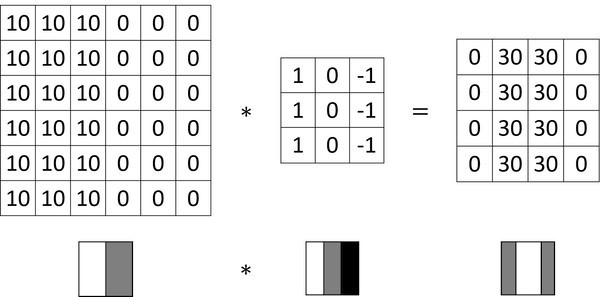

Source: Deep Learning Specialization by deeplearning.ai on Coursera

## Setup

First, we'll set up our environment by importing the necessary libraries. Since we're implementing convolution from scratch, our main requirement is PyTorch for handling tensors, but we'll avoid using its built-in convolution functions.

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import time

## Implementing Convolution From Scratch

Next, we define our convolution function. This function will take an input image (as a 2D tensor), a kernel (also a 2D tensor), and optionally, stride and padding values.

In [2]:
def conv2d_simple(input, kernel):
    """
    Performs a 2D convolution operation from scratch without padding and with a stride of 1.

    Parameters:
    - input: 2D tensor of shape (height, width).
    - kernel: 2D tensor of shape (k_height, k_width).

    Returns:
    - output: 2D tensor of shape (output_height, output_width).
    """
    # Calculate the dimensions of the output matrix
    output_height = input.shape[0] - kernel.shape[0] + 1
    output_width = input.shape[1] - kernel.shape[1] + 1
    output = torch.zeros((output_height, output_width))

    # Perform the convolution operation
    for i in range(output_height):
        for j in range(output_width):
            output[i, j] = torch.sum(
                input[i : i + kernel.shape[0], j : j + kernel.shape[1]] * kernel
            )

    return output

To visualize how this function works, let's create a simple example with an input image and a kernel. We'll use a small 3x3 kernel for edge detection.

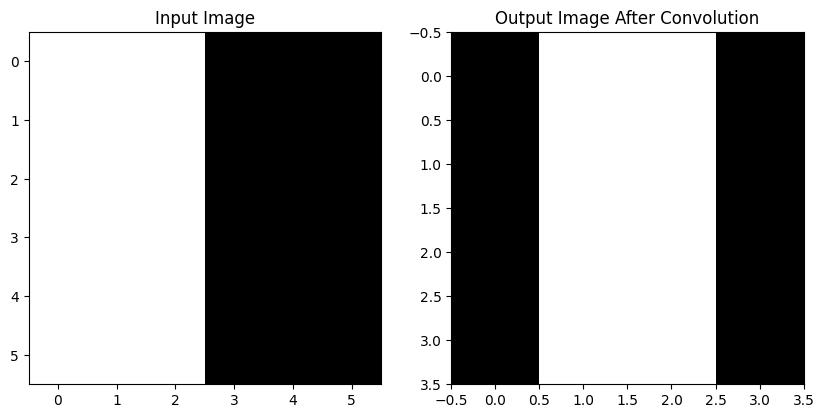

In [3]:
# Example input (an 8x8 image)
input_image = torch.tensor([
    [10, 10, 10, 0, 0, 0],
    [10, 10, 10, 0, 0, 0],
    [10, 10, 10, 0, 0, 0],
    [10, 10, 10, 0, 0, 0],
    [10, 10, 10, 0, 0, 0],
    [10, 10, 10, 0, 0, 0],
], dtype=torch.float32)

# Edge detection kernel
kernel = torch.tensor([
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]
], dtype=torch.float32)

# Apply our convolution function
output_image = conv2d_simple(input_image, kernel)

# Visualization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(input_image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Output Image After Convolution")
plt.imshow(output_image, cmap='gray')
plt.show()


This code performs a convolution operation on an 6x6 binary image using an edge detection kernel. The output image should highlight the edges detected by the convolution operation. This is a simple demonstration of how convolution can extract features from images.

### Extended Implementation

The following implementation optimizes the convolution operation using the im2col technique, which unfolds the input tensor into a matrix where each column corresponds to a patch of the input image. This transformation allows the convolution to be expressed as a matrix multiplication, significantly improving computational efficiency by leveraging optimized linear algebra routines. It starts by padding the input, calculating the output dimensions, and then iteratively extracting and reshaping each patch of the input image into columns of an unfolded tensor. This approach is preferred over traditional for-loop convolutions due to its ability to utilize parallel processing, leading to faster execution times, although it may increase memory usage due to the expanded representation of the input data.

In [4]:
def conv2d(input, filter, stride=1, padding=0):
    
    # Assume the input shape is (batch_size, in_channels, in_height, in_width)
    # Assume the kernel shape is (out_channels, in_channels, kernel_height, kernel_width)
    batch_size, in_channels, in_height, in_width = input.shape
    out_channels, _, filter_height, filter_width = filter.shape

    # Calculate the output height and width while considering the effect of padding and 
    # stride on the dimensions of the output.
    output_height = (in_height + 2 * padding - filter_height) // stride + 1
    output_width = (in_width + 2 * padding - filter_width) // stride + 1

    # Add zero-padding around the edges of each input image in the batch, so that the 
    # filter can apply to the border pixels.
    input_padded = torch.nn.functional.pad(input, (padding, padding, padding, padding))

    # Initialize the unfolded tensor for all patches
    unfolded_tensor = torch.zeros(
        (
            batch_size,
            in_channels * filter_height * filter_width,
            output_height * output_width,
        )
    )

    # Here we slide the filter over the input, and for each position we flatten the patch
    # of the image it covers and store it in the unfolded tensor.
    for i in range(output_height):
        for j in range(output_width):
            start_i = i * stride
            start_j = j * stride
            end_i = start_i + filter_height
            end_j = start_j + filter_width
            patches = input_padded[:, :, start_i:end_i, start_j:end_j]
            unfolded_tensor[:, :, i * output_width + j] = patches.reshape(
                batch_size, -1
            )

    # This reshapes the filter to be two-dimensional, with the first dimension being 
    # the number of output channels and the second being all the weights in the filter.
    filter_reshaped = (
        filter.view(out_channels, -1).unsqueeze(0).repeat(batch_size, 1, 1)
    )
    
    # This is the core of the convolution operation: a matrix multiplication between the 
    # unfolded input patches and the reshaped filter.
    output = torch.bmm(filter_reshaped, unfolded_tensor)

    # Reshape the convolved output to the expected output shape
    output = output.view(batch_size, out_channels, output_height, output_width)

    return output

### Checking the Implementations

We test the function and see whether it's result is the same as PyTorch's built in function.

In [5]:
# Initialize the same input and filters as for your custom conv2d function
input = torch.randn(10, 3, 64, 64) 
filter = torch.randn(32, 3, 3, 3)
batch_size, in_channels, input_height, input_width = input.shape
out_channels, in_channels, filter_height, filter_width = filter.shape

# Timing custom conv2d_vectorized function
start_time = time.time()
output_vectorized = conv2d(input, filter)
end_time = time.time()
time_custom_vectorized = end_time - start_time

# Using PyTorch's built-in Conv2d
conv_layer = nn.Conv2d(
    in_channels=in_channels,
    out_channels=out_channels,
    kernel_size=filter_height,
    bias=False,
)
# Manually set the weights of the Conv2d layer to match our filters
conv_layer.weight.data = filter

# Compute the output using the built-in Conv2d
# Timing built-in Conv2d
start_time_builtin = time.time()
output_builtin = conv_layer(input)
end_time_builtin = time.time()
time_builtin = end_time_builtin - start_time_builtin

# Check if the outputs are close enough
are_close = torch.allclose(output_vectorized, output_builtin, atol=1e-5)
print(f"Are the custom and built-in conv2d outputs close? {are_close}")

# Print timing results
print(f"Custom vectorized function took: {time_custom_vectorized:.6f} seconds")
print(f"PyTorch took: {time_builtin:.6f} seconds")

Are the custom and built-in conv2d outputs close? True
Custom vectorized function took: 0.157412 seconds
PyTorch took: 0.003447 seconds
